# DPT-DINOv2

In [65]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import base64
import rawpy
from IPython.display import display, HTML
import tifffile as tiff
import matplotlib.pyplot as plt

    
def display_image_small(im, width=500):
    w, h = im.size
    height = int(h * (width / w))
    image = im.resize((width, height))
    display(image)

def open_image(path, depth_path, scale=0.5, display=False):
    depth_img = tiff.imread(depth_path)
    # Display the shape of the image array
    with rawpy.imread(path) as raw_image:
        rgb = raw_image.postprocess()
        image = Image.fromarray(rgb)
        w, h = image.size
        scale = depth_img.shape[1] / w
        width = int(w * scale)
        height = int(h * scale)
        print(f"Original image size: {w}x{h}")
        print(f"Resized image size: {width}x{height}")
        image = image.resize((width, height))
        if display:
            display_image_small(image)
    return image, depth_img

def preprocess_image(image_processor, image):
    # prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")
    return inputs

def predict_depth(model, inputs):
    #forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    return predicted_depth

def post_process_depth(depth, image, display=False):
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    if display:
        display_image_small(depth)
    return output, formatted, depth

def plot_one_over_z_vs_d(actual_depth, model_output):
    # to do: adjust this according to the cvpr paper
    # plot 1/z vs d
    z = actual_depth.flatten()
    d = model_output.flatten()
    # remove zeros
    non_zero = np.where(z != 0)
    z = z[non_zero]
    d = d[non_zero]
    # normalise d
    # d = d / np.max(d)
    plt.scatter(z, 1/d, s=1)
    plt.xlabel("d")
    plt.ylabel("1/z")
    plt.show()

def underwater_depth_model_analysis(model_path, raw_image_path, actual_depth_path):
    # initialise model
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForDepthEstimation.from_pretrained(model_path)
    raw_image, actual_depth = open_image(raw_image_path, actual_depth_path, display=True)
    inputs = preprocess_image(image_processor, raw_image)
    predicted_depth = predict_depth(model, inputs)
    model_output, formatted, depth_im = post_process_depth(predicted_depth, raw_image, display=True)
    plot_one_over_z_vs_d(actual_depth, model_output[2:-2,:])


model_dinov2 ="facebook/dpt-dinov2-small-kitti"
model_dpt3_1 = "Intel/dpt-swinv2-large-384" 
model_depth_anything =  "nielsr/depth-anything-small"
img_name = "T_S03047"
raw = f"D1/Raw/{img_name}.ARW"
actual_depth_path = f"D1/depth/depth{img_name}.tif"

Original image size: 7968x5320
Resized image size: 3984x2660


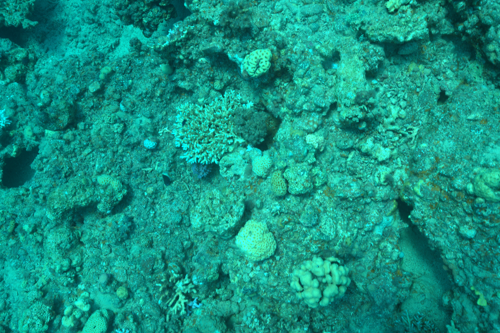

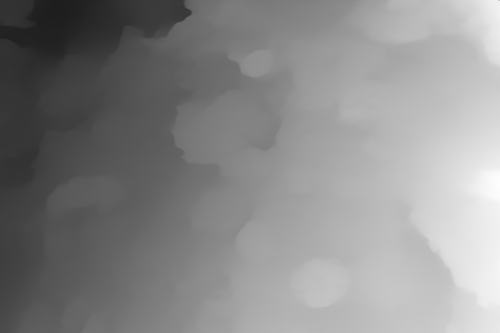

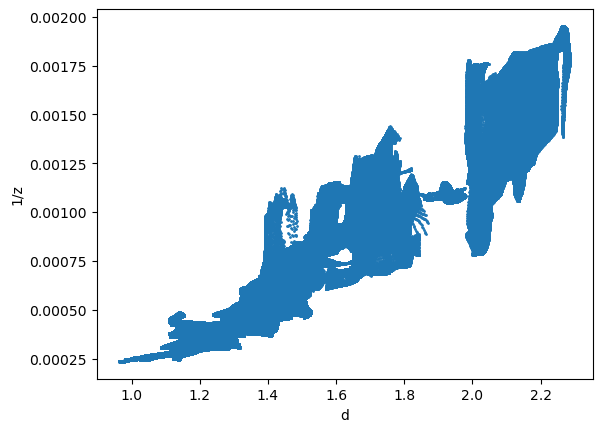

In [66]:
underwater_depth_model_analysis(model_dpt3_1, raw, actual_depth_path)

Original image size: 7968x5320
Resized image size: 3984x2660


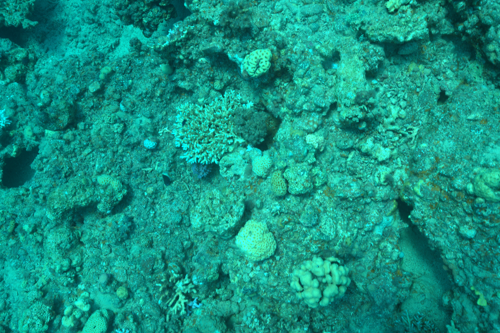

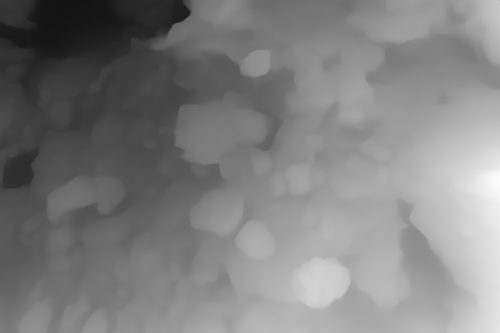

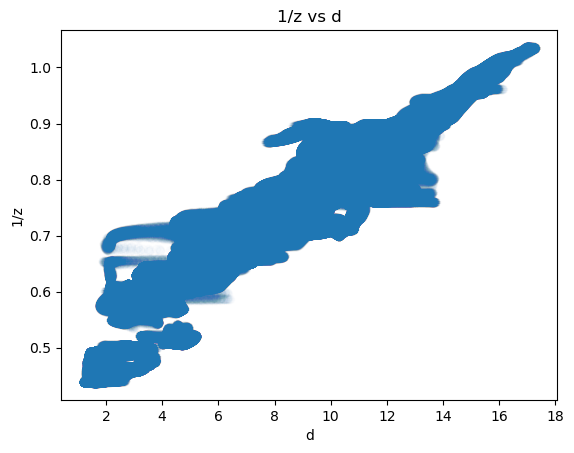

In [58]:
underwater_depth_model_analysis(model_depth_anything, raw, actual_depth_path)

Original image size: 7968x5320
Resized image size: 3984x2660


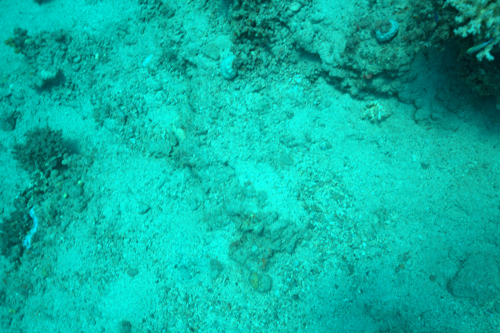

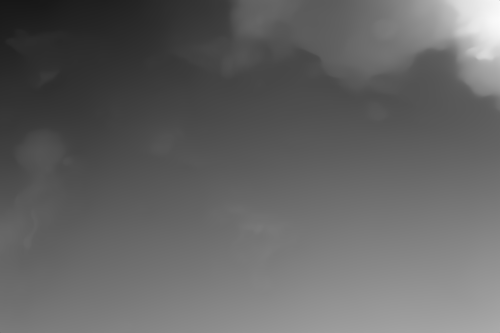

UnboundLocalError: local variable 'z' referenced before assignment

In [62]:
img_name = "T_S03128"
raw = f"D1/Raw/{img_name}.ARW"
actual_depth_path = f"D1/depth/depth{img_name}.tif"
underwater_depth_model_analysis(model_depth_anything, raw, actual_depth_path)